# Imports

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import os

from matplotlib import rc
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

# Constants

Define some constants used for the analysis

In [2]:
SCHEMA = 'https://video.udacity-data.com/topher/2018/February/5a8cb627_survey-results-schema/survey-results-schema.csv'
DATA = 'https://video.udacity-data.com/topher/2018/February/5a8cb654_survey-results-public/survey-results-public.csv'
FILES = ['schema.csv', 'data.csv']

# Getting the DATA

In [3]:
def get_data(urls, file_names, overwrite=False):
    '''
    Downloading the data and saving on local machine
    Args:
        urls -> List[str]: list of urls to CSVs
        file_names -> List[str]: list of names for local files
        overwite -> bool: overwrite existing files (default False)
    Return:
        None
    '''
    
    for ind, url in enumerate(urls):
        with requests.Session() as s:
            response = s.get(url=url)
            
            file_name = file_names[ind]
            file_exist = os.path.exists(file_name)
            
            if file_exist:
                if not overwrite:
                    return
                    
            with open(file_name, 'w') as file:
                file.write(response.text)

In [4]:
get_data([SCHEMA, DATA], FILES, overwrite=False)

In [5]:
#schema = pd.read_csv(FILES[0])
#survey = pd.read_csv(FILES[1])
schema = pd.read_csv('survey_results_schema.csv')
survey = pd.read_csv('survey_results_public.csv')

# Analysing the DATA

In [6]:
# checking the size of the dataset
nr = survey.shape[0]
nc = survey.shape[1]
text = f'There are {nr} rows and {nc} columns'
print(text)

There are 19102 rows and 154 columns


In [7]:
# We are now searching the columns where there is no missing values
survey.info()
# This function, even if is gives, usually, the numbers of rows and also shows where there are missing values,
# is not convenient for this question as it can't be auotmated

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19102 entries, 0 to 19101
Columns: 154 entries, Respondent to ExpectedSalary
dtypes: float64(6), int64(1), object(147)
memory usage: 22.4+ MB


In [8]:
columns_wo_na = survey.columns[~survey.isna().any()]
print(f'The following columns have no missing values:\n{", ".join(columns_wo_na.values)}')

The following columns have no missing values:
Respondent, Professional, ProgramHobby, Country, University, EmploymentStatus, FormalEducation


In [9]:
# We want to find the columns where more than 75% of the values are missing
columns_with_most_na = survey.columns[(survey.isna().sum() / nr) > 0.75]
columns_with_most_na

Index(['YearsCodedJobPast', 'WebDeveloperType', 'MobileDeveloperType',
       'NonDeveloperType', 'ExCoderReturn', 'ExCoderNotForMe',
       'ExCoderBalance', 'ExCoder10Years', 'ExCoderBelonged', 'ExCoderSkills',
       'ExCoderWillNotCode', 'ExCoderActive', 'TimeAfterBootcamp',
       'ExpectedSalary'],
      dtype='object')

In [10]:
# We will create a reduced size dataset to play with
reduced_survey = survey.loc[:, survey.columns.isin(columns_wo_na)]

In [11]:
reduced_survey.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree


In [12]:
# Changing the index to be the Column index: each row will have the header as index
schema.set_index(keys='Column', drop=True, inplace=True)

In [13]:
schema.head()

,Question
Column,
Respondent,Respondent ID number
Professional,Which of the following best describes you?
ProgramHobby,Do you program as a hobby or contribute to ope...
Country,In which country do you currently live?
University,"Are you currently enrolled in a formal, degree..."


In [14]:
# Description of the features in reduced_survey dataframe
schema.loc[reduced_survey.columns]

,Question
Respondent,Respondent ID number
Professional,Which of the following best describes you?
ProgramHobby,Do you program as a hobby or contribute to ope...
Country,In which country do you currently live?
University,"Are you currently enrolled in a formal, degree..."
EmploymentStatus,Which of the following best describes your cur...
FormalEducation,Which of the following best describes the high...


In [15]:
#### Setting some default values for below charts
font = {'size': 18, 'family': 'ubuntu'}
axes = {'labelsize': 20, 'titlesize': 24, 
        'spines.left': False,
        'spines.right': False,
        'spines.top': False,
        'spines.bottom': False
       }
figure = {'figsize': (7, 5), 'dpi': 100}
lines = {'linewidth': 4, 'linestyle': '-.'}

rc('font', **font)
rc('axes', **axes)
rc('figure', **figure)

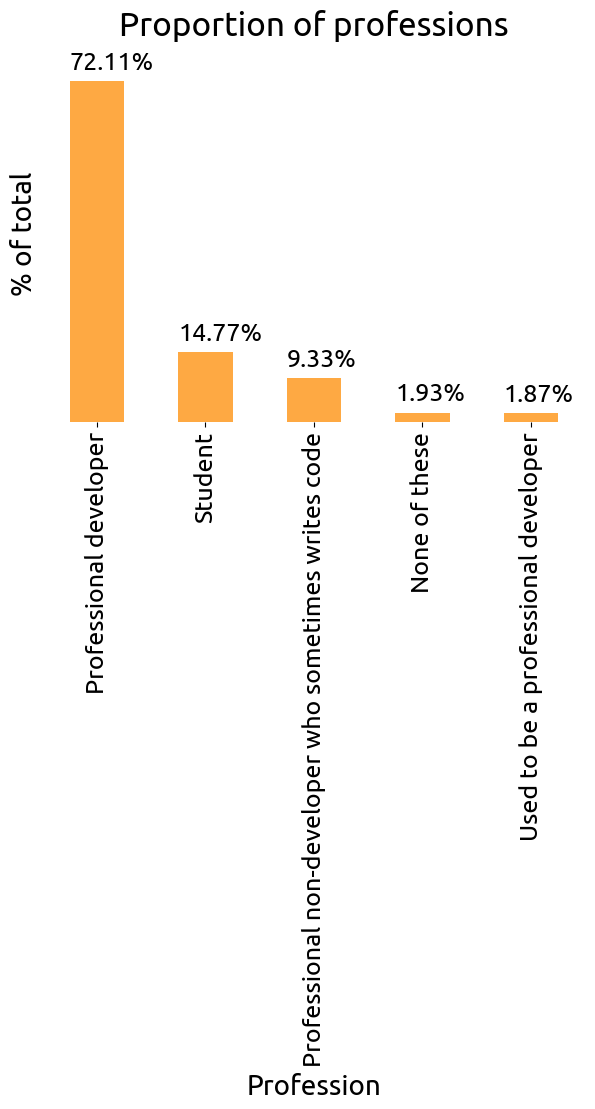

In [16]:
pro_count = reduced_survey['Professional'].value_counts() / nr
pro_count.plot(kind='bar', color='#FEA943')
ax = plt.gca()
ax.set_title('Proportion of professions')
ax.set_xlabel('Profession')
ax.set_ylabel('% of total')
ax.set_ylim([0, 0.8])
ax.set_yticks([])
for ind, cat in enumerate(pro_count.index):
    ax.text(ind-0.25, pro_count[cat]+0.025, f'{pro_count[cat]:.2%}')
plt.show()

With 70% of the surveyees, the survey was mostly taken by professional developers. 16% are students and occasional developers 10%.

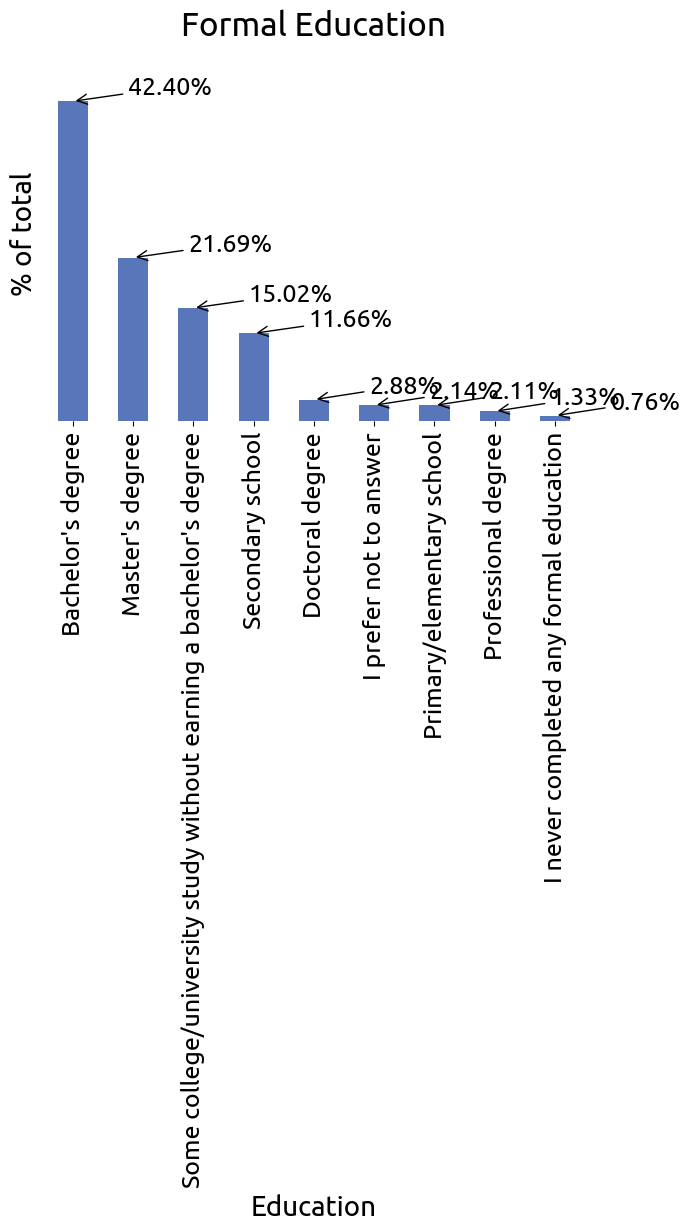

In [17]:
ed_vals = reduced_survey['FormalEducation'].value_counts() / nr
ed_vals.plot(kind='bar', color='#5A76BA')
ax = plt.gca()
ax.set_title('Formal Education')
ax.set_xlabel('Education')
ax.set_ylabel('% of total')
ax.set_ylim([0, 0.5])
ax.set_yticks([])
for ind, cat in enumerate(ed_vals.index):
    ax.annotate(
        s=f'{ed_vals[cat]:.2%}',
        xy=(ind, ed_vals[cat]),
        xycoords='data',
        xytext=(40, 5),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->')
    )
plt.show()

Around 66% of the surveyee have at least a Batchelor degree.

How much of the professional developers have at least a batchelor degree?

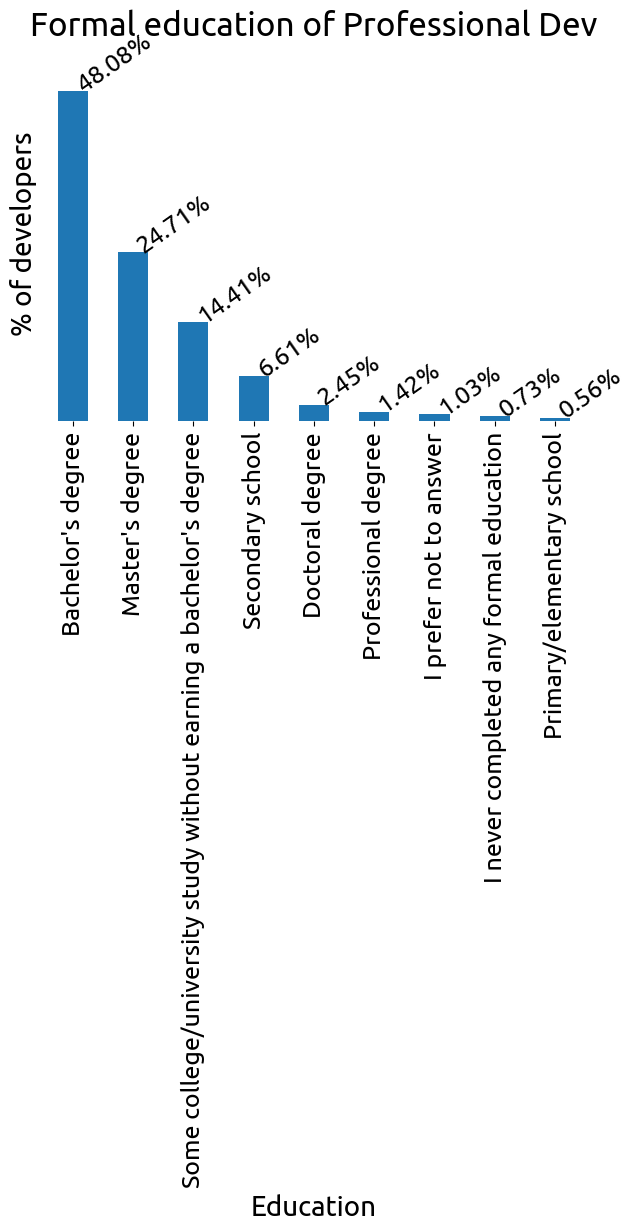

In [18]:
pro_dev = reduced_survey.query('Professional == "Professional developer"')
pro_dev_ed = pro_dev['FormalEducation'].value_counts() / pro_dev.shape[0]
pro_dev_ed.plot(kind='bar')
ax = plt.gca()
ax.set_title('Formal education of Professional Dev')
ax.set_xlabel('Education')
ax.set_ylabel('% of developers')
ax.set_ylim([0, 0.55])
ax.set_yticks([])
for ind, cat in enumerate(pro_dev_ed.index):
    ax.text(x=ind, 
            y=pro_dev_ed[cat], 
            s='{:.2%}'.format(pro_dev_ed[cat]),
            rotation=35)
plt.show()

Around 75% of professional developers who answered the survey have at least a batchelor degree.

In [19]:
print('There is a total of {} countries in the survey.'.format(reduced_survey['Country'].nunique()))

There is a total of 165 countries in the survey.


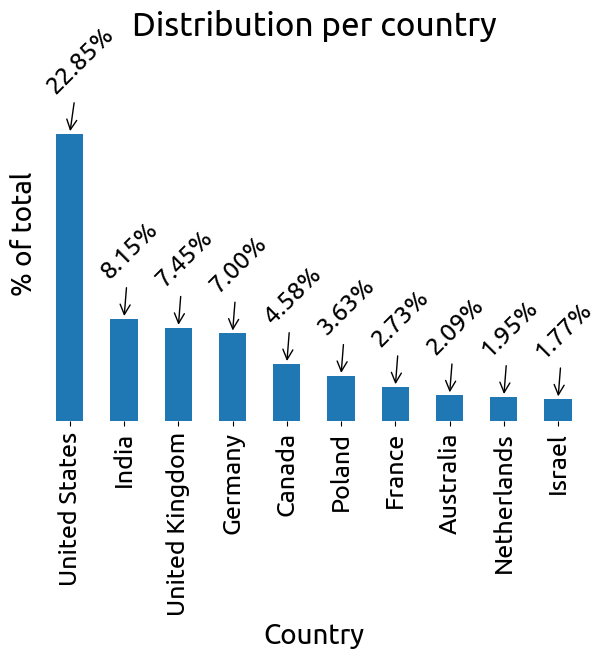

In [20]:
count_per_country = reduced_survey['Country'].value_counts() / nr
count_per_country[:10].plot(kind='bar')
ax = plt.gca()
ax.set_title('Distribution per country')
ax.set_xlabel('Country')
ax.set_ylabel('% of total')
ax.set_ylim([0, 0.3])
ax.set_yticks([])
for ind, cat in enumerate(count_per_country[:10].index):
    ax.annotate(
        s=f'{count_per_country[cat]:.2%}',
        xy=(ind, count_per_country[cat]),
        xycoords='data',
        xytext=(-20, 30),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->'),
        rotation=45
    )
plt.show()

With 22% of surveyee, US is the country with most answers to the survey. India, UK and Germany are altogether at around 30%. All the others are below 5%. US, India, UK and Germany reprensent 50% of all surveyee, on a total of 201 countries in the survey.

# Deeper look into the data

We will look into the available columns and see if we can get more insights about it

In [21]:
for s in schema.index:
    print(f'{s:20}:\t{schema.loc[s].values[0]}')

Respondent          :	Respondent ID number
Professional        :	Which of the following best describes you?
ProgramHobby        :	Do you program as a hobby or contribute to open source projects?
Country             :	In which country do you currently live?
University          :	Are you currently enrolled in a formal, degree-granting college or university program?
EmploymentStatus    :	Which of the following best describes your current employment status?
FormalEducation     :	Which of the following best describes the highest level of formal education that you've completed?
MajorUndergrad      :	Which of the following best describes your main field of study (aka 'major') in college or university/for your undergraduate studies?
HomeRemote          :	How often do you work from home or remotely?
CompanySize         :	In terms of the number of employees, how large is the company or organization you work for?
CompanyType         :	Which of the following best describes the type of company or o

We are interested to see what are the advises the surveyees will be giving to their cousin if they were to decide to change career for developer.

# Professional advises

We are interested to learn what are the most common advises that surveyee are giving. For this purpose, they were asked to answer to a question about what would be the advise(s) they will be giving to a cousin if he/she wanted to start a career in computer science.

In [22]:
advises = survey['CousinEducation'].value_counts() / nr

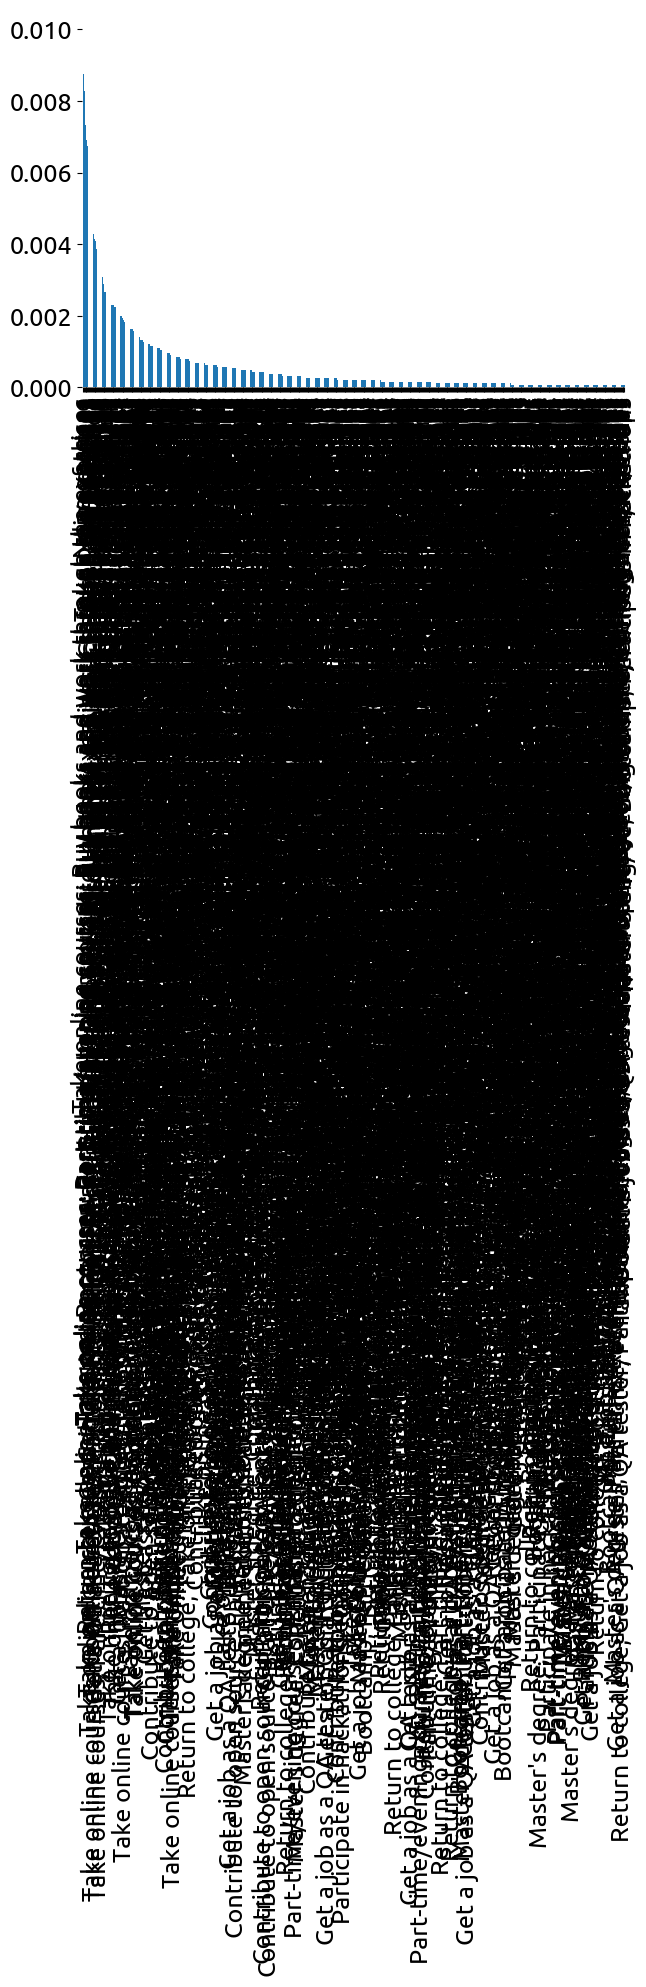

In [23]:
advises.plot(kind='bar')

It is obvious this representation is difficult to read: surveyee could select several answers to the question and therefore, there are many different answer in each row. We need to separate the answer for each row.

In [24]:
def get_unique_values(df, column_name, sep=';'):
    """
    return a list of all unique values in a column.
    Especially useful when a column can present several values per row
    """
    possible_values = set()
    for r in df[column_name].value_counts().index.tolist():
        vals = [v.strip() for v in r.split(sep)]
        for v in vals:
            possible_values.add(v)
            
    return possible_values

In [25]:
possible_values = get_unique_values(survey, 'CousinEducation', sep='; ')
print(possible_values)

{'Take online courses', 'Contribute to open source', 'Conferences/meet-ups', 'Participate in online coding competitions', 'Participate in hackathons', 'Bootcamp', 'Other', "Master's degree", 'Get a job as a QA tester', 'Part-time/evening courses', 'None of these', 'Return to college', 'Buy books and work through the exercises'}


In [26]:
def get_count_per_cat(df, column_name, sep=';'):
    """
    """
    possible_values = get_unique_values(df, column_name, sep)
    count_vals = df[column_name].value_counts()
    
    cat_vals = dict()
    for k, v in zip(count_vals.index, count_vals):
        for i in k.split(sep=sep):
            cat_vals[i] = cat_vals.get(i, 0) + v
        
    return cat_vals

In [27]:
def get_cousin_education_cats(df):
    new_df = pd.DataFrame.from_dict(
        get_count_per_cat(df, 'CousinEducation', sep='; '),
        orient='index',
        columns=['count']
    )
    new_df.sort_values(by='count', ascending=False, inplace=True)
    return new_df / new_df.sum()

In [28]:
df_advises = pd.DataFrame.from_dict(
    get_count_per_cat(survey, 'CousinEducation', sep='; '),
    orient='index',
    columns=['count'],
)
df_advises.sort_values(by='count', ascending=False, inplace=True)
df_advises = df_advises / df_advises.sum()

In [29]:
df_advises = get_cousin_education_cats(survey)

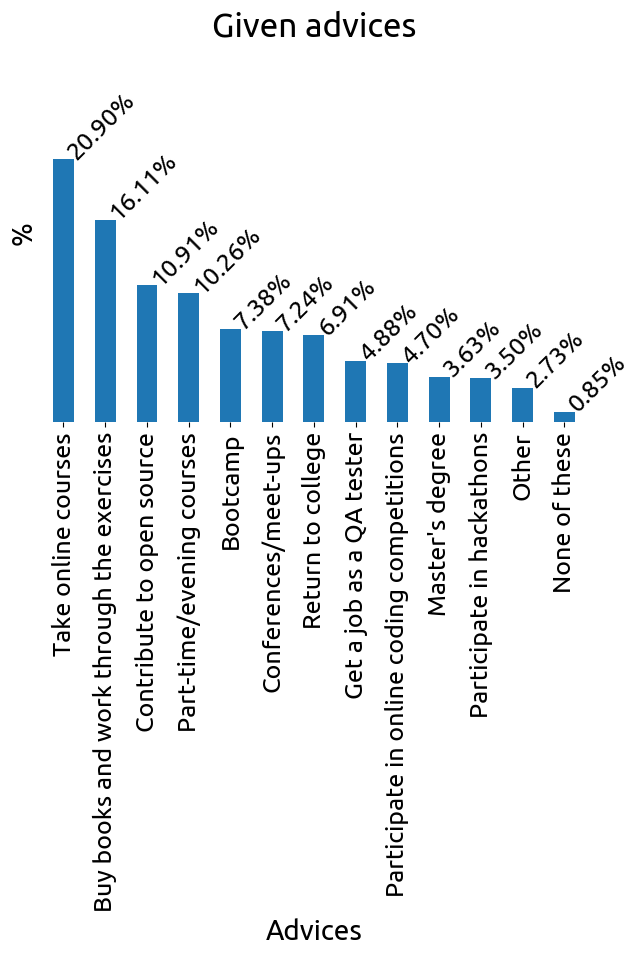

In [30]:
df_advises['count'].plot(kind='bar')
ax = plt.gca()
ax.set_title('Given advices')
ax.set_xlabel('Advices')
ax.set_ylabel('%')
ax.set_ylim([0, 0.3])
ax.set_yticks([])
for ind, cat in enumerate(df_advises.index):
    ax.text(
        x=ind,
        y=float(df_advises.loc[cat]),
        s=f'{float(df_advises.loc[cat]):.2%}',
        rotation=45
    )
plt.show()

With ~21%, "taking online courses" is the most given advice. The second most given advice, with ~16%, is "buying books and work through the exercices". The third and forth advices, with ~10% each, are "part-time/evening courses" and "contribute to open source". 
Not all online courses are rewarded by a certificate of complition, but most of them rely on the participation of the students in exercises that they should do on their own, in a given online platform or on the local machines. The second advice, "reading books and work through the exercises", also emphasis the importance of working on exercises. The next advices rely on the students doing some sort of exercises/application of the knowledge they acquire, like practicing code development by contributing to "open source", "participating in online coding competitions", etc. 

It is interesting to see what professional developers answered to above question:

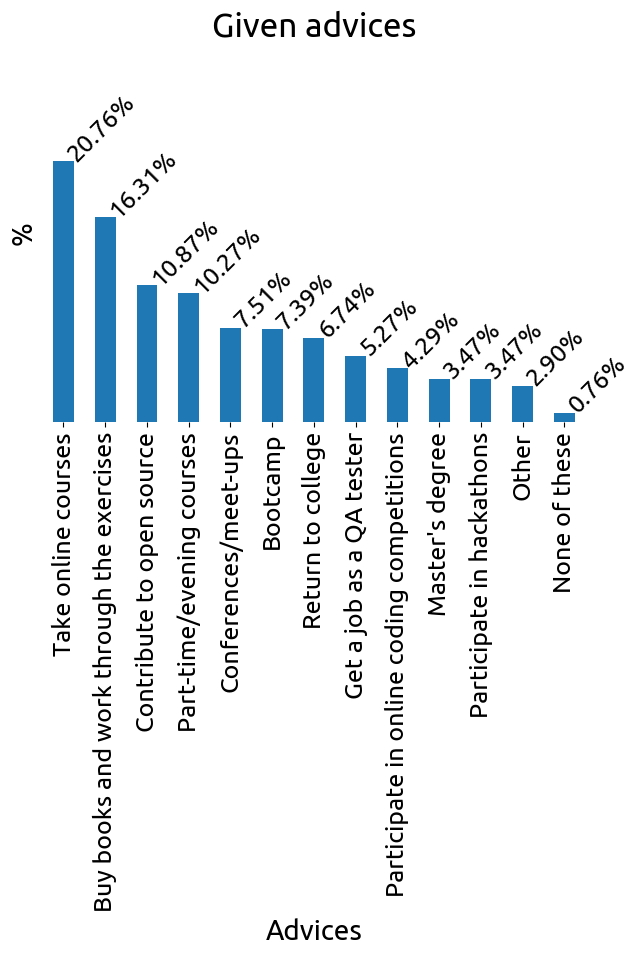

In [31]:
df_advises = pd.DataFrame.from_dict(
    get_count_per_cat(survey[survey['Professional'] == "Professional developer"], 
                      'CousinEducation', 
                      sep='; '),
    orient='index',
    columns=['count'],
)
df_advises.sort_values(by='count', ascending=False, inplace=True)
df_advises = df_advises / df_advises.sum()

df_advises['count'].plot(kind='bar')
ax = plt.gca()
ax.set_title('Given advices')
ax.set_xlabel('Advices')
ax.set_ylabel('%')
ax.set_ylim([0, 0.3])
ax.set_yticks([])
for ind, cat in enumerate(df_advises.index):
    ax.text(
        x=ind,
        y=float(df_advises.loc[cat]),
        s=f'{float(df_advises.loc[cat]):.2%}',
        rotation=45
    )
plt.show()

The advices give by professional developers seem to follow the same trend as seen in previous chart. Could it be that most advices were given by professional developers? Let's have a look.

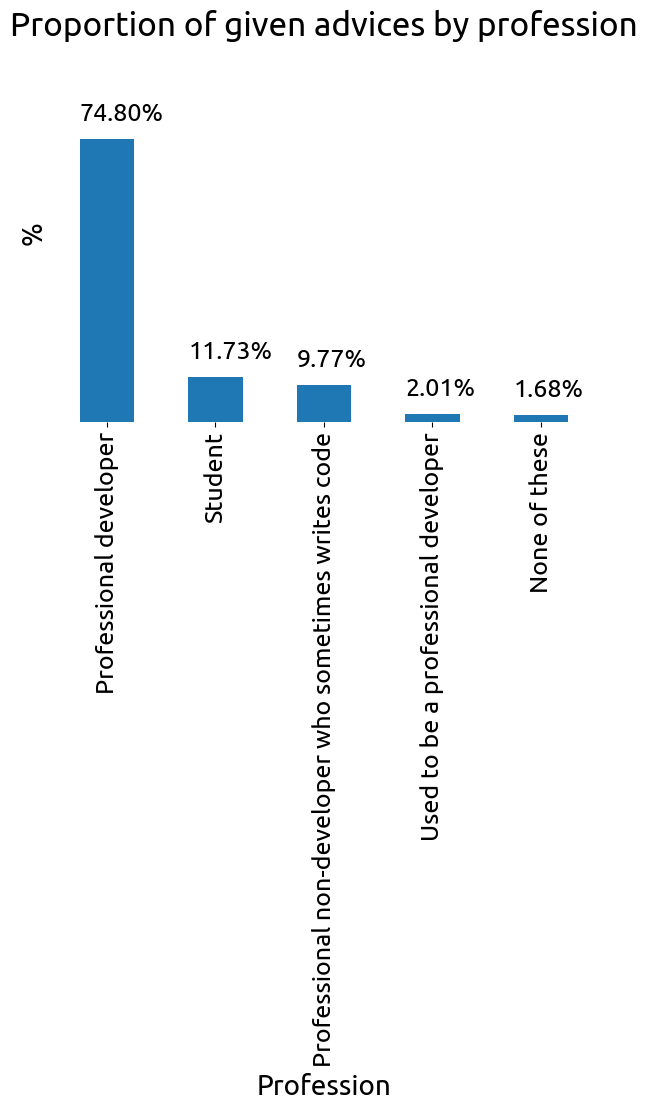

In [32]:
surveyee_advices = survey[~survey['CousinEducation'].isnull()]['Professional'].value_counts()
surveyee_advices = (surveyee_advices / surveyee_advices.sum())
surveyee_advices.plot(kind='bar')
ax = plt.gca()
ax.set_title('Proportion of given advices by profession')
ax.set_xlabel('Profession')
ax.set_ylabel('%')
ax.set_ylim([0, 1])
ax.set_yticks([])
for ind, cat in enumerate(surveyee_advices.index):
    ax.text(
        x=ind-0.25,
        y=surveyee_advices[cat]+0.05,
        s=f'{surveyee_advices[cat]:.2%}'
    )
plt.show()

Most of the advices were given by professional developers and it would explain the similarity between the two previous charts. Let's have a look at what non-professional developers advises most.

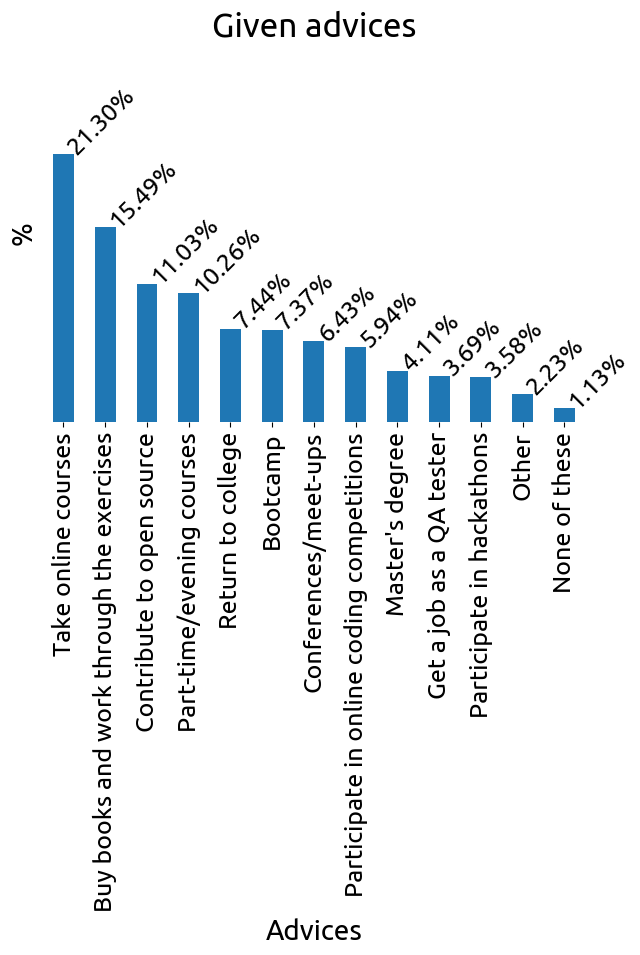

In [33]:
df_advises = pd.DataFrame.from_dict(
    get_count_per_cat(survey[survey['Professional'] != "Professional developer"], 
                      'CousinEducation', 
                      sep='; '),
    orient='index',
    columns=['count'],
)
df_advises.sort_values(by='count', ascending=False, inplace=True)
df_advises = df_advises / df_advises.sum()

df_advises['count'].plot(kind='bar')
ax = plt.gca()
ax.set_title('Given advices')
ax.set_xlabel('Advices')
ax.set_ylabel('%')
ax.set_ylim([0, 0.3])
ax.set_yticks([])
for ind, cat in enumerate(df_advises.index):
    ax.text(
        x=ind,
        y=float(df_advises.loc[cat]),
        s=f'{float(df_advises.loc[cat]):.2%}',
        rotation=45
    )
plt.show()

It seems there is a general agreement between professional and non-professional developers as of the best ways of learning to be a developers: all the four first most advised advices are the same for both category. And those 4 first possible way of learning represent each time ~56%.

We would like to see if higher education surveyee have been given biased advises toward higher education.

In [34]:
def find_higher_ed(ed):
    """
    return 1 if ed is in ("Master's degree", "Doctoral degree", "Professional degree")
    return 0 otherwise
    """
    higher_ed_degree = ("Master's degree", "Doctoral degree", "Professional degree")
    
    return 1 if ed in higher_ed_degree else 0

In [35]:
survey['HigherEd'] = survey['FormalEducation'].apply(find_higher_ed)
survey['HigherEd'].head(10)

0    0
1    0
2    0
3    1
4    1
5    0
6    1
7    1
8    0
9    1
Name: HigherEd, dtype: int64

In [36]:
only_advices = survey[~survey['CousinEducation'].isnull()]
ht_ed_gp = only_advices.query("HigherEd == 1")
lw_ed_gp = only_advices.query("HigherEd == 0")

In [37]:
lw_ad = get_cousin_education_cats(lw_ed_gp)
ht_ad = get_cousin_education_cats(ht_ed_gp)
ad = lw_ad.merge(ht_ad, left_index=True, right_index=True)
ad.columns = ['LowEd', 'HighEd']

In [38]:
ad['Diff'] = ad['HighEd'] - ad['LowEd']
ad.style.bar(subset='Diff', align='mid', color=['red', 'green'])

,LowEd,HighEd,Diff
Take online courses,0.210682,0.204275,-0.006407
Buy books and work through the exercises,0.160746,0.161878,0.001132
Contribute to open source,0.109009,0.109320,0.000311
Part-time/evening courses,0.103668,0.099860,-0.003808
Conferences/meet-ups,0.075483,0.063945,-0.011537
Bootcamp,0.073681,0.074282,0.000601
Return to college,0.068726,0.070252,0.001526
Get a job as a QA tester,0.049099,0.047828,-0.001271
Participate in online coding competitions,0.048520,0.042922,-0.005598
Participate in hackathons,0.035972,0.032235,-0.003736


Interesting visual that shows that there is no significant bias of surveyee who detain a higher degree toward a higher degree. There is indeed a small increase in response suggesting a Master degree or to return to college, but those advices are not, in general, significant as they are not often given.

# Cleaning data and preparing it for data modeling

We would like to be able to predict the salary (target) with respect to all the other different features. The data present many NA values, in the salary column as well. Also, most of the features are categorical and therefore we will have to transform those features so we can use them within our model.

First, we will get rid of all the rows where the target, salary, is missing, as we won't be able to predict anything with it.

In [39]:
survey.shape

(19102, 155)

In [40]:
# We first create a copy of the dataset
if 'df' in locals():
    df = survey.copy()
else:
    df = survey.copy()

In [55]:
def create_dummy_vars(df:pd.DataFrame, dummy_na: bool=False):
    """
    function that will create dummy variables for all categorical features in df
    """
    df = df.copy() # create local copy of df so the external var won't be changed
    
    # determining categorical cols
    cat_cols = df.select_dtypes(include=['object']).columns
    
    # Commented: solution by Udacity -> can be improved using pandas capabilities (faster execution)
    
    # for cat in cat_cols:
    #     try:
    #         df = pd.concat([
    #             df.drop(labels=cat, axis=1),
    #             pd.get_dummies(
    #                 data=df[cat],
    #                 prefix=cat,
    #                 prefix_sep='_',
    #                 drop_first=True, 
    #                 dummy_na=dummy_na
    #             )
    #         ], axis=1
    #         )
    #     except:
    #         continue
    
    df = pd.get_dummies(
        data=df,
        columns=cat_cols,
        prefix=cat_cols,
        prefix_sep='_',
        dummy_na=dummy_na, 
        drop_first=True
    )
        
    return df
    
def clean_transform_data(df: pd.DataFrame, target: str, dummy_na: bool=False):
    """
    function that will apply different cleaning and transformation to df
    """
    print('Making a copy of df...')
    df = df.copy() # create local copy of df so the external var won't be changed
    
    # removing all missing values from Salary
    print('Removing missing values from target...')
    df = df.dropna(subset=[target], axis=0)

    # removing all columns with only missing values
    print('Removing all columns with only missing values...')
    df = df.dropna(axis=1, how='all')
    
    # create dummy vars
    print('Creating dummies variables from categorical features...')
    df = create_dummy_vars(df, dummy_na=dummy_na)
    
    # fill missing values with mean of column
    print('Filling missing values with mean value of column...')
    fill_mean = lambda col: col.fillna(col.mean())
    df = df.apply(fill_mean, axis=0)
    
    # create X and y
    print('Creating X and y...')
    X, y = df.drop(labels=target, axis=1), df[target]
    
    # split X and y into training and testing sets
    print('Spliting dataset to training and testing sets...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # creating and fitting the model
    print('Creating linear model and using training data to train it...')
    lm = LinearRegression(normalize=True)
    lm.fit(X_train, y_train)
    
    # using the model for prediction on training and testing sets
    print('Using linear model to predict target on training and testing sets...')
    y_pred_train = lm.predict(X_train)
    y_pred_test = lm.predict(X_test)
    
    # model training and testing scores
    print('Calculating model scores on training and testing sets...')
    train_score = r2_score(y_train, y_pred_train)
    test_score = r2_score(y_test, y_pred_test)
    
    print(f'Training R2 score is {train_score:.4%}\nTesting R2 score is {test_score:.4%}')
    
    return train_score, test_score, lm, X_train, X_test, y_train, y_test

In [46]:
%%time
df_new = df.dropna(subset=['Salary'], axis=0)
df_new = create_dummy_vars(df_new, dummy_na=False)

print(df_new.shape)

(5009, 11939)
CPU times: user 5.6 s, sys: 1.28 s, total: 6.88 s
Wall time: 6.88 s


In [54]:
%%time

cat_cols = df.select_dtypes(include=['object']).columns
df_new_2 = df.dropna(subset=['Salary'], axis=0)

df_new_2 = pd.get_dummies(
    data=df_new_2,
    columns=cat_cols,
    prefix=cat_cols, 
    prefix_sep='_', 
    drop_first=True,
    dummy_na=False
)

print(df_new_2.shape)

(5009, 11939)
CPU times: user 420 ms, sys: 15.8 ms, total: 436 ms
Wall time: 435 ms


In [47]:
%%time
train_score, test_score, lm, X_train, X_test, y_train, y_test = clean_transform_data(df_new, target='Salary', dummy_na=False)

Making a copy of df...
Removing missing values from target...
Removing all columns with only missing values...
Creating dummies variables from categorical features...
Filling missing values with mean value of column...
Creating X and y...
Spliting dataset to training and testing sets...
Creating linear model and using training data to train it...
Using linear model to predict target on training and testing sets...
Calculating model scores on training and testing sets...
Training R2 score is 100.0000%
Testing R2 score is 45.4615%
CPU times: user 44.5 s, sys: 602 ms, total: 45.1 s
Wall time: 24.7 s


There is a big difference betweek the training and testing score. This is due to overfitting of the model on the training dataset.

In [56]:
%%time
train_score, test_score, lm, X_train, X_test, y_train, y_test = clean_transform_data(df_new, target='Salary', dummy_na=False)

Making a copy of df...
Removing missing values from target...
Removing all columns with only missing values...
Creating dummies variables from categorical features...
Filling missing values with mean value of column...
Creating X and y...
Spliting dataset to training and testing sets...
Creating linear model and using training data to train it...
Using linear model to predict target on training and testing sets...
Calculating model scores on training and testing sets...
Training R2 score is 100.0000%
Testing R2 score is 45.4615%
CPU times: user 48.4 s, sys: 618 ms, total: 49 s
Wall time: 26.7 s


Above cell is a test using a different approach to code dummy variables. Two cells above, I have used the solution proposed in te course but I realized it was slowe